In [3]:
# Import parking garage
import MDAnalysis as mda
import MDAnalysisData
import zarr
import h5py
import numcodecs
import os
import subprocess
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time
from MDAnalysis.core.topology import Topology
from MDAnalysis.core.topologyattrs import Atomids, Atomnames
os.chdir('benchmark_files')



In [4]:
# Setup yiip data
yiip = MDAnalysisData.yiip_equilibrium.fetch_yiip_equilibrium_short()
u = mda.Universe(yiip.topology, yiip.trajectory)
positions = mda.Universe(yiip.topology, yiip.trajectory, in_memory=True).trajectory.get_array()

print(np.max(positions))

YiiP_system.pdb: 0.00B [00:00, ?B/s]

YiiP_system.pdb: 8.84MB [00:03, 2.88MB/s]                            
YiiP_system_9ns_center.xtc: 373MB [00:22, 16.2MB/s]                               
/nfs/homes3/ljwoods2/.conda/envs/zarrtraj/lib/python3.11/site-packages/MDAnalysis/topology/PDBParser.py:348: UserWarning: Unknown element Z found for some atoms. These have been given an empty element record. If needed they can be guessed using MDAnalysis.topology.guessers.
  warnings.warn(wmsg)
/nfs/homes3/ljwoods2/.conda/envs/zarrtraj/lib/python3.11/site-packages/MDAnalysis/topology/PDBParser.py:348: UserWarning: Unknown element D found for some atoms. These have been given an empty element record. If needed they can be guessed using MDAnalysis.topology.guessers.
  warnings.warn(wmsg)
/nfs/homes3/ljwoods2/.conda/envs/zarrtraj/lib/python3.11/site-packages/MDAnalysis/topology/guessers.py:146: UserWarning: Failed to guess the mass for the following atom types: D
  warnings.warn("Failed to guess the mass for the following atom types: {}"

135.99


In [5]:

print(np.min(positions))

-35.31


In [8]:
# Convenience methods

def generate_traj(n_atoms):
    frames = 100
    # Generate positions array using min and max position value from yiip_equilibrium
    pos = (135.99 + 35.31) * np.random.random_sample((frames, n_atoms, 3)) - 35.31
    pos = pos.astype('float32')
    return pos

def filesize(filename):
    return int(subprocess.check_output(['du','-s', filename]).split()[0].decode('utf-8'))

def exponential_range(start, stop, step):
    return [pow(10, i) for i in range(start, stop, step)]

# Don't use this with randomly generated data unless
# you know n_atoms matches a topology
def it(filename, i=None):
    filename, file_extension = os.path.splitext(filename)
    if file_extension != '.zarr':
        start = time.time()
        for i in range(11):
            n_atoms = pow(10, i)
            iterate_mda(filename, n_atoms, file_extension)
        stop = time.time()
        return stop - start
    else:
        start = time.time()
        for i in range(11):
            iterate_zarr(filename)
        stop = time.time()
        return stop - start

def iterate_mda(filename, n_atoms, file_extension):
    atom_ids = Atomids(np.arange(n_atoms))
    atom_names = Atomnames(np.array(['X']*n_atoms))
    topology = Topology(n_atoms, 0, 0, attrs=[atom_ids, atom_names])
    print(file_extension[1:].upper())
    u = mda.Universe(topology, file_extension[1:].upper())
    u.load_new(filename)
    num = 0
    for ts in u.trajectory:
        num += ts[0][0]

def iterate_zarr(filename):
    z = zarr.open(filename, 'r')
    p = z['positions']
    num = 0
    for f in p:
        num += f[0][0]


    


In [9]:
compressor = numcodecs.Blosc(cname='zstd', clevel=9)
compressor2 = numcodecs.Blosc(cname='zstd', clevel=0)

for i in range(3, 8):
    n_atoms = pow(10, i)
    traj = generate_traj(n_atoms)
    u = mda.Universe(traj)

    with mda.Writer(f"10e{i}_xtc.xtc", n_atoms) as w:
        for ts in u.trajectory:
            w.write(u.atoms)

    with mda.Writer(f"10e{i}_trr.trr", n_atoms) as w:
        for ts in u.trajectory:
            w.write(u.atoms)   
    
    with mda.Writer(f"10e{i}_h5md_c.h5md", n_atoms, compression='gzip', compression_opts=9, convert_units=False) as w:
        for ts in u.trajectory:
            w.write(u.atoms)   

    with mda.Writer(f"10e{i}_h5md_un.h5md", n_atoms, convert_units=False) as w:
        for ts in u.trajectory:
            w.write(u.atoms)   

    root = zarr.open(f"10e{i}_zarr_c.zarr", mode='w')
    root.create_dataset('positions', data=traj, 
                        chunks = (1, n_atoms, 3), 
                        compressor=compressor)

    root2 = zarr.open(f"10e{i}_zarr_un.zarr", mode='w')
    root2.create_dataset('positions', data=traj, 
                        chunks = (1, n_atoms, 3), 
                        compressor=compressor2)
    

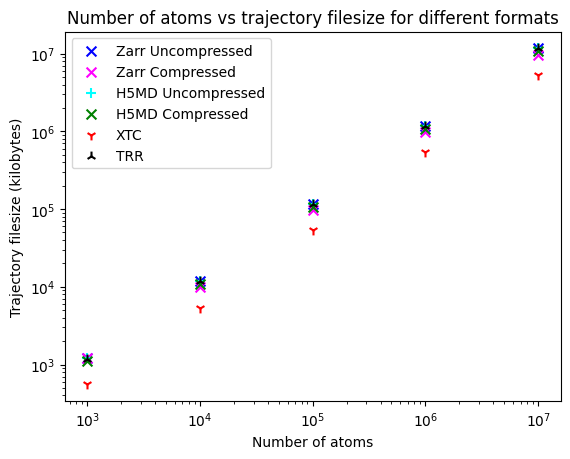

In [24]:
n = np.logspace(3, 7, 5)

x_filesize = []
t_filesize = []
z_filesize = []
z_c_filesize = []
h_filesize =[]
h_c_filesize =[]

for i in range(3, 8, 1):
    x_filesize.append(filesize(f'10e{i}_xtc.xtc'))
    t_filesize.append(filesize(f'10e{i}_trr.trr'))
    z_filesize.append(filesize(f'10e{i}_zarr_un.zarr'))
    z_c_filesize.append(filesize(f'10e{i}_zarr_c.zarr'))
    h_filesize.append(filesize(f'10e{i}_h5md_un.h5md'))
    h_c_filesize.append(filesize(f'10e{i}_h5md_c.h5md'))


# Graph zarrtraj size vs h5 size
plt.title('Number of atoms vs trajectory filesize for different formats')
plt.xlabel('Number of atoms')
plt.ylabel('Trajectory filesize (kilobytes)')
plt.xscale('log')
plt.yscale('log')

plt.scatter(n, z_filesize, c='blue', s=50, label="Zarr Uncompressed", marker='x')
plt.scatter(n, z_c_filesize, c='magenta', s=50, label="Zarr Compressed", marker='x')
plt.scatter(n, h_filesize, c='cyan', s=50, label="H5MD Uncompressed", marker='+')
plt.scatter(n, h_c_filesize, c='green', s=50, label="H5MD Compressed", marker='x')
plt.scatter(n, x_filesize, c='red', s=50, label="XTC", marker='1')
plt.scatter(n, t_filesize, c='black', s=50, label="TRR", marker='2')

plt.legend()



In [ ]:
n = n.astype('int')
n_atoms = np.tile(n, 6)
formats = ['Zarr compressed' for _ in range(5)] + ['Zarr uncompressed' for _ in range(5)] + ['H5MD compressed' for _ in range(5)] + ['H5MD uncompressed' for _ in range(5)] + ['XTC' for _ in range(5)] + ['TRR' for _ in range(5)]
fsizes = z_c_filesize + z_filesize + h_c_filesize + h_filesize + x_filesize + t_filesize

data = {'Format' : formats, 'Number of atoms' : n_atoms, 'Filesize (kilobyte)' : fsizes} 
df = pd.DataFrame(data)

# Displaying the table
print(df)

In [27]:
# YIIP size and iteration time tests
compressor = numcodecs.Blosc(cname='zstd', clevel=9)
compressor2 = numcodecs.Blosc(cname='zstd', clevel=0)

u = mda.Universe(yiip.topology, yiip.trajectory)

with mda.Writer(f"yiip_xtc.xtc", n_atoms) as w:
    for ts in u.trajectory:
        w.write(u)

with mda.Writer(f"yiip_trr.trr", n_atoms) as w:
    for ts in u.trajectory:
        w.write(u)   

with mda.Writer(f"yiip_h5md_c.h5md", n_atoms, compression='gzip', compression_opts=9, convert_units=False) as w:
    for ts in u.trajectory:
        w.write(u)   

with mda.Writer(f"yiip_h5md_un.h5md", n_atoms, convert_units=False) as w:
    for ts in u.trajectory:
        w.write(u)   

root = zarr.open(f"yiip_zarr_c.zarr", mode='w')
root.create_dataset('positions', data=positions, 
                    chunks = (1, n_atoms, 3), 
                    compressor=compressor)

root2 = zarr.open(f"yiip_zarr_un.zarr", mode='w')
root2.create_dataset('positions', data=positions, 
                    chunks = (1, n_atoms, 3), 
                    compressor=compressor2)

/nfs/homes3/ljwoods2/.conda/envs/zarrtraj/lib/python3.11/site-packages/MDAnalysis/topology/PDBParser.py:348: UserWarning: Unknown element Z found for some atoms. These have been given an empty element record. If needed they can be guessed using MDAnalysis.topology.guessers.
  warnings.warn(wmsg)
/nfs/homes3/ljwoods2/.conda/envs/zarrtraj/lib/python3.11/site-packages/MDAnalysis/topology/PDBParser.py:348: UserWarning: Unknown element D found for some atoms. These have been given an empty element record. If needed they can be guessed using MDAnalysis.topology.guessers.
  warnings.warn(wmsg)
/nfs/homes3/ljwoods2/.conda/envs/zarrtraj/lib/python3.11/site-packages/MDAnalysis/topology/guessers.py:146: UserWarning: Failed to guess the mass for the following atom types: D
  warnings.warn("Failed to guess the mass for the following atom types: {}".format(atom_type))
/nfs/homes3/ljwoods2/.conda/envs/zarrtraj/lib/python3.11/site-packages/MDAnalysis/topology/guessers.py:146: UserWarning: Failed to gu

TypeError: only length-1 arrays can be converted to Python scalars

In [29]:
u = mda.Universe(yiip.topology, yiip.trajectory)

for ts in u.trajectory:
    print(ts.n_atoms)

/nfs/homes3/ljwoods2/.conda/envs/zarrtraj/lib/python3.11/site-packages/MDAnalysis/topology/PDBParser.py:348: UserWarning: Unknown element Z found for some atoms. These have been given an empty element record. If needed they can be guessed using MDAnalysis.topology.guessers.
  warnings.warn(wmsg)
/nfs/homes3/ljwoods2/.conda/envs/zarrtraj/lib/python3.11/site-packages/MDAnalysis/topology/PDBParser.py:348: UserWarning: Unknown element D found for some atoms. These have been given an empty element record. If needed they can be guessed using MDAnalysis.topology.guessers.
  warnings.warn(wmsg)
/nfs/homes3/ljwoods2/.conda/envs/zarrtraj/lib/python3.11/site-packages/MDAnalysis/topology/guessers.py:146: UserWarning: Failed to guess the mass for the following atom types: D
  warnings.warn("Failed to guess the mass for the following atom types: {}".format(atom_type))
/nfs/homes3/ljwoods2/.conda/envs/zarrtraj/lib/python3.11/site-packages/MDAnalysis/topology/guessers.py:146: UserWarning: Failed to gu

111815
111815
111815
111815
111815
111815
111815
111815
111815
111815
111815
111815
111815
111815
111815
111815
111815
111815
111815
111815
111815
111815
111815
111815
111815
111815
111815
111815
111815
111815
111815
111815
111815
111815
111815
111815
111815
111815
111815
111815
111815
111815
111815
111815
111815
111815
111815
111815
111815
111815
111815
111815
111815
111815
111815
111815
111815
111815
111815
111815
111815
111815
111815
111815
111815
111815
111815
111815
111815
111815
111815
111815
111815
111815
111815
111815
111815
111815
111815
111815
111815
111815
111815
111815
111815
111815
111815
111815
111815
111815
111815
111815
111815
111815
111815
111815
111815
111815
111815
111815
111815
111815
111815
111815
111815
111815
111815
111815
111815
111815
111815
111815
111815
111815
111815
111815
111815
111815
111815
111815
111815
111815
111815
111815
111815
111815
111815
111815
111815
111815
111815
111815
111815
111815
111815
111815
111815
111815
111815
111815
111815
111815
111815

KeyboardInterrupt: 